In [35]:
cd /home/mil/kawana/workspace/superquadric_parsing/supershape

/home/mil/kawana/workspace/superquadric_parsing/supershape


In [36]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import math
from models import periodic_shape_sampler
from models import super_shape_sampler
from models import super_shape
import utils
from losses import custom_chamfer_loss
import numpy as np
import random
import tqdm
from collections import defaultdict
from torch.autograd import Variable
import torch.optim as optim
import pickle

In [37]:
seed = 0
random.seed(seed)  
np.random.seed(seed)  
# PyTorch のRNGを初期化  
torch.manual_seed(seed)

scale tensor([[[1.8431, 1.5062],
         [1.7684, 1.6410]]], grad_fn=<AddBackward0>)
2 2 1000 2
torch.Size([2, 2, 1000, 2])
(2, 1000, 2)


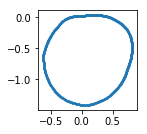

In [38]:
b = 2
n_primitives = 2
max_m = 2
thetas_points_num = 1000
points_num = 100
dim = 2
thetas = torch.linspace(0., 2. * math.pi, thetas_points_num)
points = torch.linspace(0., 2. * math.pi, points_num)
batched_points = points.view(1, -1, 1).repeat(b, 1, dim)
batched_thetas = thetas.view(1, -1).repeat(b, 1)

net = periodic_shape_sampler.PeriodicShapeSampler(points_num, n_primitives=n_primitives, max_m=max_m, factor=1, mode='delta', learn_pose=True, linear_scaling=False)

test_primitive = super_shape.SuperShapes(max_m, n_primitives)

param = test_primitive()
print('scale', param['linear_scale'])
super_shape_point, surface_mask, tsd = net(batched_points, param, thetas=batched_thetas)
print(super_shape_point.shape)
assert [*super_shape_point.shape] == [b, n_primitives, thetas_points_num, dim]
plotxy = super_shape_point[:, 0, :, :].detach().cpu().numpy()
fig = plt.figure()
g = fig.add_subplot(1, 3, 1)
g.set_aspect('equal')
print(plotxy.shape)
g.scatter(plotxy[0, :, 0], plotxy[0, :, 1], s=1)




1 2 1000 2
1 2 1000 2
1 2 1000 2
0.9103556
e2 numerator tensor([[689]])
E tensor([1.0025])
joint reg 0.05254584550857544


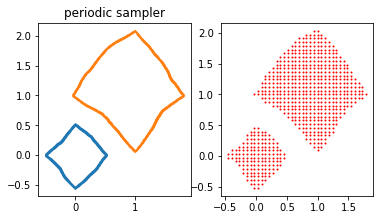

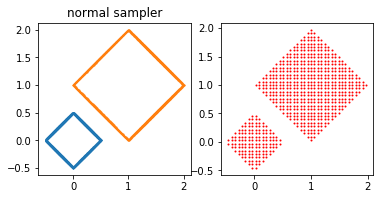

In [39]:
b = 1
linear_scaling = True
n_primitives = 2
max_m = 4
thetas_points_num = 1000
points_num = 100
dim = 2
test_thetas = torch.linspace(0., 2. * math.pi, thetas_points_num)
test_points = torch.linspace(0., 2. * math.pi, points_num)
batched_points = test_points.view(1, -1, 1).repeat(b, 1, dim)
batched_thetas = test_thetas.view(1, -1).repeat(b, 1)

test_xs, test_ys = utils.generate_grid_samples(3, batch=b, sample_num=100)
test_plot_xs = test_xs.view(-1).detach().cpu().numpy()
test_plot_ys = test_ys.view(-1).detach().cpu().numpy()

net = periodic_shape_sampler.PeriodicShapeSampler(points_num, n_primitives=n_primitives, max_m=max_m, factor=1, mode='delta', learn_pose=True, linear_scaling=linear_scaling)
net2 = super_shape_sampler.SuperShapeSampler(max_m, n_primitives, learn_pose=True, linear_scaling=linear_scaling)

param = utils.generate_multiple_primitive_params(max_m, 1, 1, 1, 1, 1, transitions=[[0., 0.], [1, 1]], linear_scales=[[1., 1.], [2., 2.]])

super_shape_point, surface_mask, tsd = net(batched_points, param, thetas=batched_thetas, xs=test_xs, ys=test_ys)

assert [*super_shape_point.shape] == [b, n_primitives, thetas_points_num, dim]
fig = plt.figure()
g = fig.add_subplot(1, 2, 1)
for idx in range(n_primitives):
  plotxy = super_shape_point[:, idx, :, :].detach().cpu().numpy()
  g.set_title('periodic sampler')
  g.set_aspect('equal')
  g.scatter(plotxy[0, :, 0], plotxy[0, :, 1], s=1)

test_plot_tsd = (nn.functional.relu(nn.functional.sigmoid(tsd*100))).sum(1).view(-1).detach().cpu().numpy()
g = fig.add_subplot(1, 2, 2)
g.set_aspect('equal')
g.scatter(test_plot_xs[test_plot_tsd>0.5], test_plot_ys[test_plot_tsd>0.5], c=[1, 0, 0], s=1)


fig2 = plt.figure()
g2 = fig2.add_subplot(1, 2, 1)
for idx in range(n_primitives):
  super_shape_point2, surface_mask2, tsd2 = net2(param, thetas=batched_thetas, xs=test_xs, ys=test_ys)
  plotxy2 = super_shape_point2[:, idx, :, :].detach().cpu().numpy()
  g2.set_title('normal sampler')
  g2.set_aspect('equal')
  g2.scatter(plotxy2[0, :, 0], plotxy2[0, :, 1], s=1)
test_plot_tsd2 = (nn.functional.relu(nn.functional.sigmoid(tsd2*100))).sum(1).view(-1).detach().cpu().numpy()
g2 = fig2.add_subplot(1, 2, 2)
g2.set_aspect('equal')
g2.scatter(test_plot_xs[test_plot_tsd2>0.5], test_plot_ys[test_plot_tsd2>0.5], c=[1, 0, 0], s=1)

print(plotxy[0, 0, 0]/plotxy2[0, 0, 0])

sigmoid_predicted_tsd = nn.functional.sigmoid(tsd2 * 100)
all_predicted_tsd = sigmoid_predicted_tsd.sum(1)

E1numerator = (sigmoid_predicted_tsd > 0.5).sum(2)
E1numerator_nonzero = torch.where(E1numerator == 0, torch.ones_like(E1numerator), E1numerator)
E1 = ( 2 * sigmoid_predicted_tsd ).sum(2) / E1numerator_nonzero
E1 = torch.where(E1numerator == 0, torch.zeros_like(E1), E1)
E2numerator =  (all_predicted_tsd > 0.5).sum(1).view(b, 1)
E2numerator_nonzero = torch.where(E2numerator == 0, torch.ones_like(E2numerator), E2numerator)
E2 = all_predicted_tsd.view(b, 1, -1).repeat(1, n_primitives, 1).clamp(max=2).sum(2) / E2numerator_nonzero
E = (E1 - E2).max(1)[0]
print('e2 numerator',  (all_predicted_tsd > 0.5).sum(1).view(b, 1))
#print('e1 bunshi', (sigmoid_predicted_tsd > 0.5).sum(2))
#print('nonzero', (sigmoid_predicted_tsd > 0.5).sum(2))
#print('E1 bunbo',  ( 2 * sigmoid_predicted_tsd ).sum(2))
print('E', E)
joint_reg = nn.functional.relu(E - 0.95).mean()
print('joint reg', joint_reg.item())

In [43]:
thetas = torch.linspace(0., 2. * math.pi, 1000)

In [49]:
M = 4
N = 6
B = 10
learning_rate = .01
iters = 1000
train_point_sample = 100
train_grid_sample = 20
eval_point_sample = 100
eval_grid_sample = 500
grid_size = 3
gt_from_file=True
train_implicit=True
rational=True
periodicnet = True
device_type = 'cuda:7'
train_periodic_after_abstraction = False

periodicnet = train_periodic_after_abstraction
device = torch.device(device_type)

if periodicnet:
  ocoef = 10.
  ccoef = 1.
else:
  ocoef = 1.
  ccoef = 1.

#ccoef = 0.
#ocoef = 0.
overlap_reg_coef = 1.


if gt_from_file:
  gt_point = np.stack(pickle.load(open('/home/mil/kawana/workspace/superquadric_parsing/2_2.pkl', 'rb')), axis=-1)[np.newaxis, ...]
  gt_point = torch.tensor(gt_point).to(device)
  xss, yss, sgns = pickle.load(open('/home/mil/kawana/workspace/superquadric_parsing/2_std_2.pkl', 'rb'))
  xss = torch.tensor(xss, device=device).float()
  yss = torch.tensor(yss, device=device).float()
  sgns = torch.tensor(sgns, device=device).float()

else:
  # B=1, P, 2
  gt_point = surface_point.view(1, -1, 2).to(device)
  sgns = nn.functional.sigmoid(nn.functional.sigmoid(tsd * 100).sum(1)).view(1, -1).to(device).repeat(B, 1)

  #gt_point = super_shape_point_single.view(1, -1, 2).to(device)
  #sgns = nn.functional.sigmoid(nn.functional.sigmoid(tsd_single * 100).sum(1)).view(1, -1).to(device).repeat(B, 1)

if periodicnet:
  gt_point_feed = gt_point.repeat(B, 1, 1)

if train_periodic_after_abstraction:
  primitive.eval()
else:
  primitive = super_shape.SuperShapes(M, N, rational=rational, train_linear_scale=True, quadrics=True, train_ab=False)
  primitive.to(device)

if not train_periodic_after_abstraction:
  assert not periodicnet

if periodicnet or train_periodic_after_abstraction:
  print('Train periodic net')
  mode = 'delta' if train_periodic_after_abstraction else 'scratch'
  sampler = periodic_shape_sampler.PeriodicShapeSampler(gt_point.shape[1], n_primitives=N, max_m=M, factor=16, linear_scaling=True, learn_pose=True, act='leaky', mode=mode)
  optimizer = optim.Adam(sampler.parameters(), lr=learning_rate)

else:
  print('Train super shape')
  sampler = super_shape_sampler.SuperShapeSampler(M, N, rational=rational)
  optimizer = optim.Adam(primitive.parameters(), lr=learning_rate)

sampler.to(device)

#optimizer = adabound.AdaBound(primitive.parameters(), lr=learning_rate)
torch.autograd.set_detect_anomaly(True)

losses = []
for idx in tqdm.tqdm(range(iters)):
  optimizer.zero_grad()

  # Ensure polar coordinate samples are closed at 0 and 2 pi.
  train_point = torch.empty((train_point_sample - 2) * B, device=device).uniform_(0, 2. * math.pi).view(B, -1)
  train_point = torch.cat([train_point, torch.tensor([0.], device=device).view(1, 1).repeat(B, 1), torch.tensor([2. * math.pi], device=device).view(1, 1).repeat(B, 1)], axis=1)

  if gt_from_file:
    index = random.sample(range(len(xss)), B * train_grid_sample ** 2)
    xs = xss[index].view(B, -1)
    ys = yss[index].view(B, -1)
    gt_sgn = sgns[index].view(B, -1)
  else:
    xs, ys = utils.generate_grid_samples(plot_grid_size, B, sampling='grid', sample_num=plot_sample_num, device=device)
    gt_sgn = sgns
  if train_implicit:
    if periodicnet:
      print(gt_point.shape, train_point.shape)
      predicted_super_shape_point, predicted_surface_mask, predicted_tsd = sampler(gt_point_feed, primitive(), thetas=train_point, xs=xs, ys=ys)
    else:
      predicted_super_shape_point, predicted_surface_mask, predicted_tsd = sampler(primitive(), thetas=train_point, xs=xs, ys=ys)
  else:
    if periodicnet:
      print(gt_point_feed.shape, train_point.shape)
      predicted_super_shape_point, predicted_surface_mask, _ = sampler(gt_point_feed, primitive(), thetas=train_point)
    else:    
      predicted_super_shape_point, predicted_surface_mask, _ = sampler(primitive(), thetas=train_point)
  if train_implicit:
    print(predicted_tsd.shape)
    sigmoid_predicted_tsd = nn.functional.sigmoid(predicted_tsd * 100)
    all_predicted_tsd = sigmoid_predicted_tsd.sum(1)

    overlap_reg = (nn.functional.relu(all_predicted_tsd - 1.2).abs()).mean()

    E1numerator = (sigmoid_predicted_tsd > 0.5).sum(2)
    E1numerator_nonzero = torch.where(E1numerator == 0, torch.ones_like(E1numerator), E1numerator)
    E1 = ( 2 * sigmoid_predicted_tsd ).sum(2) / E1numerator_nonzero
    E1 = torch.where(E1numerator == 0, torch.zeros_like(E1), E1)
    E1 = E1.clamp(max=2)
    E2numerator =  (all_predicted_tsd > 0.5).sum(1).view(B, 1)
    E2numerator_nonzero = torch.where(E2numerator == 0, torch.ones_like(E2numerator), E2numerator)
    E2 = all_predicted_tsd.view(B, 1, -1).repeat(1, N, 1).clamp(max=2).sum(2) / E2numerator_nonzero
    E = (E1 - E2).max(1)[0]
    #print('E1', E1)
    #print('E2', E2)
    #print('E', E)
    #print('E1 - E2', E1 - E2)
    joint_reg = nn.functional.relu(E - .95).mean()
    # oloss = ((all_predicted_tsd - gt_sgn) ** 2.).mean()
    oloss = nn.functional.binary_cross_entropy_with_logits(all_predicted_tsd.clamp(min=1e-7), gt_sgn)

  # Make sure angle 0 and 2 pi fall to same coordinate.
  close_reg = ((predicted_super_shape_point[:, :, -1] - predicted_super_shape_point[:, :, -2])**2).mean()

  
  prob_param = primitive()['prob']
  probsum = nn.functional.sigmoid(prob_param).sum()
  persimony_reg = nn.functional.relu(1 * B - probsum) + 1e-3 * (probsum).sqrt() 



  # Surface point loss
  # Surface point (B=1, P, 2)
  closs = custom_chamfer_loss.custom_chamfer_loss(predicted_super_shape_point, gt_point, surface_mask=predicted_surface_mask, prob=None)
  reg = close_reg * 10 + overlap_reg * overlap_reg_coef #+ joint_reg#+ persimony_reg * 0.01
  loss = closs * ccoef + oloss * ocoef  + reg #

  #loss =  reg + oloss
  print(closs.item(), reg.item(), loss.item(), oloss.item(), joint_reg.item())
  losses.append(closs.detach().cpu().numpy())
  loss.backward(retain_graph=True)
  optimizer.step()

primitive.eval()
sampler.eval()
print(primitive()['prob'])

eval_point = torch.linspace(0., 2. * math.pi, eval_point_sample, device=device).unsqueeze(0)
xs, ys = utils.generate_grid_samples(grid_size, 1, sampling='uniform', sample_num=eval_grid_sample, device=device)
if periodicnet:
  predicted_super_shape_point, predicted_surface_mask, predicted_tsd = sampler(gt_point, primitive(), thetas=eval_point, xs=xs, ys=ys)
else:
  predicted_super_shape_point, predicted_surface_mask, predicted_tsd = sampler(primitive(), thetas=eval_point, xs=xs, ys=ys)
predicted_super_shape_point_plot = predicted_super_shape_point.detach().cpu().numpy()
predicted_surface_point_plot = sampler.extract_super_shapes_surface_point(predicted_super_shape_point, primitive(), points=gt_point).detach().cpu().numpy()
plot_xs = xs.view(-1).detach().cpu().numpy()
plot_ys = ys.view(-1).detach().cpu().numpy()
plot_tsd = nn.functional.relu(predicted_tsd).sum(1).view(-1).detach().cpu().numpy()
gt_point_plot = gt_point.detach().cpu().numpy()
prob = primitive()['prob'].view(-1).detach().cpu().numpy()

7it/s]torch.Size([10, 6, 400])
0.1350119262933731 0.003903057659044862 0.810576856136322 0.671661913394928 0.01065014023333788
10 6 100 2





 90%|█████████ | 905/1000 [04:00<00:26,  3.59it/s]torch.Size([10, 6, 400])
0.1336904615163803 0.00415263045579195 0.8103340268135071 0.6724908947944641 0.016401344910264015
10 6 100 2





 91%|█████████ | 906/1000 [04:00<00:25,  3.63it/s]torch.Size([10, 6, 400])
0.13223788142204285 0.003346908139064908 0.8065961599349976 0.6710113883018494 0.019559090957045555
10 6 100 2





 91%|█████████ | 907/1000 [04:00<00:24,  3.78it/s]torch.Size([10, 6, 400])
0.13095784187316895 0.00359663600102067 0.8086885213851929 0.6741340160369873 0.01301263552159071
10 6 100 2





 91%|█████████ | 908/1000 [04:01<00:24,  3.81it/s]torch.Size([10, 6, 400])
0.13281187415122986 0.0044628651812672615 0.810165524482727 0.672890841960907 0.014175290241837502
10 6 100 2





 91%|█████████ | 909/1000 [04:01<00:24,  3.67it/s]torch.Size([10, 6, 400])
0.13204990327358246 0.0

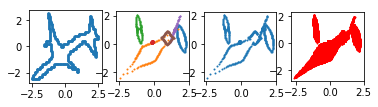

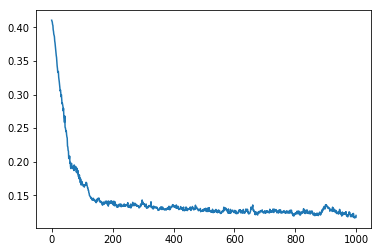

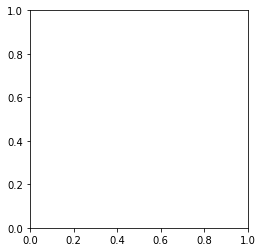

In [51]:


scatter_point_size = 1
fig = plt.figure()
g = fig.add_subplot(1, 4, 1)
g.set_aspect('equal')
g.scatter(gt_point_plot[0, :, 0], gt_point_plot[0, :, 1], s=scatter_point_size)
g2 = fig.add_subplot(1, 4, 2)
g2.set_aspect('equal')
for idx in range(predicted_super_shape_point_plot.shape[1]):
  g2.scatter(predicted_super_shape_point_plot[0, idx, :, 0], predicted_super_shape_point_plot[0, idx, :, 1], s=scatter_point_size)
  #if prob[idx] >= 0.5 or True:
#g2.scatter(gt_point_plot[0, :, 0], gt_point_plot[0, :, 1], s=scatter_point_size)

predicted_surface_point_plot_xy = predicted_surface_point_plot.reshape(-1, 2)
plot_surface_point_x, plot_surface_point_y = predicted_surface_point_plot_xy[:, 0], predicted_surface_point_plot_xy[:, 1]

g3 = fig.add_subplot(1, 4, 3)
g3.set_aspect('equal')
g3.scatter(plot_surface_point_x, plot_surface_point_y, s=scatter_point_size)

g4 = fig.add_subplot(1, 4, 4)
g4.set_aspect('equal')
g4.scatter(plot_xs[plot_tsd>0], plot_ys[plot_tsd>0], c=[1, 0, 0], s=scatter_point_size)

fig2 = plt.figure()
g5 = fig2.add_subplot(1, 1, 1)
g5.plot(losses)

fig3 = plt.figure()
g6 = fig3.add_subplot(1, 1, 1)
g6.set_aspect('equal')
